# Working interface models

In [11]:
%matplotlib widget
import time
from bmcs_expsim.utils.mlab_decorators import decorate_figure
from mayavi import mlab
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import warnings
import matplotlib.pylab as plt
import numpy as np
from ibvpy.api import TStepBC , TFCyclicNonsymmetricConstant, TFBilinear
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_interface import XDomainFEInterface
from ibvpy.fets import FETS2D4Q
from ibvpy.fets.fets1D5 import FETS1D52ULRH
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from bmcs_matmod.slide.vslide_34_TN_axisym import Slide34
from ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic import \
    MATS3DElastic
from ibvpy.tmodel.mats2D.mats2D_elastic.vmats2D_elastic import \
    MATS2DElastic
from bmcs_matmod.slide.slide_explorer import SlideExplorer

# Single material point

In [7]:
%%capture
import numpy as np
material_params = dict(
    E_T=1e6, gamma_T=0, K_T=0, S_T=100, c_T=1, bartau=6, 
    E_N=1e6, S_N=300, c_N = 1, m = 0.1, f_t=6, f_c=500, f_c0=400, eta=0.)

eta_range = [0]
se_N_list = []
se_T_list = []

for eta in eta_range:
    material_params['eta'] = eta
    se1 = SlideExplorer(n_steps=300, k_max=50)
    se1.slide_model.trait_set(**material_params)
    se1.trait_set(s_x_1 = 0, s_y_1 = 0, w_1 = 0.0001);
    se1.run()
    se_N_list.append(se1)



    se2 = SlideExplorer(n_steps=300, k_max=50)
    se2.slide_model.trait_set(**material_params)
    se2.trait_set(s_x_1 =  0.0001, s_y_1 = 0, w_1 = 0);
    se2.run()
    se_T_list.append(se2)

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…
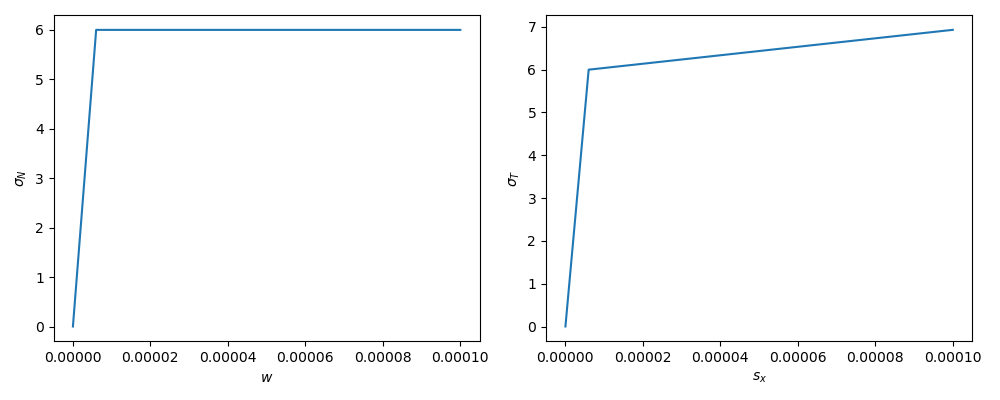

In [9]:
import matplotlib.pylab as plt
fig, (ax_N,  ax_T) = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
fig.canvas.header_visible=False

for se1, se2 in zip(se_N_list, se_T_list):

    tau_x_pi_1, tau_y_pi_1, sig_pi_1, Z_1, X_x_1, X_y_1, Y_T_1, Y_N_1 = se1.Sig_arr.T
    tau_x_pi_2, tau_y_pi_2, sig_pi_2, Z_2, X_x_2, X_y_2, Y_T_2, Y_N_2 = se2.Sig_arr.T

    w_1 = np.linspace(0, se1.w_1, n_step_1)
    s_x_2 = np.linspace(0, se2.s_x_1, n_step_2)

    ax_N.plot(w_1, sig_pi_1)
                 
    ax_N.set_xlabel('$w$')
    ax_N.set_ylabel('$\sigma_N$')

    ax_T.plot(s_x_2, tau_x_pi_2)
    ax_T.set_xlabel('$s_x$')
    ax_T.set_ylabel('$\sigma_T$')

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…
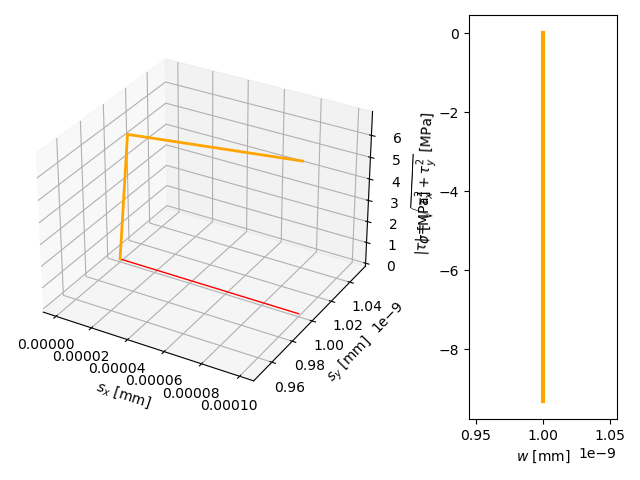

In [10]:
se2.interact()

# FE Axisymmetric discretization

In [39]:
n_y_e = 1
n_inner_x_e = 1
n_outer_x_e = 1
L_x = 1.0
P = 1.0
R_in = P / (2 * np.pi)
# R_in = 1
R_out = 2 * R_in
xd_lower = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                         coord_min=(0, 0),
                          coord_max=(L_x, R_in),
                          shape=(n_y_e, n_inner_x_e),
                          fets=FETS2D4Q())
xd_upper = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                         coord_min=(0, R_in),
                          coord_max=(L_x, R_out),
                          shape=(n_y_e, n_outer_x_e),
                          fets=FETS2D4Q())
m1 = MATS3DElastic(E=37000, nu=0.18)
m2 = MATS3DElastic(E=37000, nu=0.18)

xd12 = XDomainFEInterface(
    integ_factor =  2 * np.pi * R_in,
    I=xd_lower.mesh.I[:, -1],
    J=xd_upper.mesh.I[:, 0],
    fets=FETS1D52ULRH()
)

In [44]:
xd_lower.mesh.I

In [31]:
material_params =  dict(
     E_T=1e7, gamma_T=0, K_T=0, S_T=5, c_T=6, bartau=3, 
     E_N=1e7, S_N=5, c_N = 3, m = 0.1, f_t=2, f_c=60, f_c0 = 40, eta=0.)
bond_m = Slide34(**material_params)

In [32]:
m = TStepBC(
    domains=[(xd_lower, m1),
             (xd_upper, m2),
             (xd12, bond_m),
             ]
)

## Compression/Traction fc

In [33]:
lower_fixed_1 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
lower_fixed_0 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

lower_slide_dummy = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=0.001)
lower_slide_dofs = lower_slide_dummy.dofs


upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
         var='u', dims=[1], value=0.01)

compression_dofs = upper_compression_slice.dofs
compression = -20 / len(compression_dofs)
upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression) 
             for dof in compression_dofs ]
bc1 = [lower_fixed_0, lower_fixed_1] + upper_compression_force_first

In [34]:
compression

-10.0

In [35]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 100
s.tline.step = 0.01
s.tstep.fe_domain.serialized_subdomains

In [36]:
xd12.hidden = True
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(1), 
	 0.02(1), 
	 0.03(1), 
	 0.04(1), 
	 0.05(1), 
	 0.06(1), 
	 0.07(1), 
	 0.08(1), 
	 0.09(1), 
	 0.10(1), 
	 0.11(1), 
	 0.12(1), 
	 0.13(1), 
	 0.14(1), 
	 0.15(1), 
	 0.16(1), 
	 0.17(1), 
	 0.18(1), 
	 0.19(1), 
	 0.20(1), 
	 0.21(1), 
	 0.22(1), 
	 0.23(1), 
	 0.24(1), 
	 0.25(1), 
	 0.26(1), 
	 0.27(1), 
	 0.28(1), 
	 0.29(1), 
	 0.30(1), 
	 0.31(1), 
	 0.32(1), 
	 0.33(1), 
	 0.34(1), 
	 0.35(1), 
	 0.36(1), 
	 0.37(1), 
	 0.38(1), 
	 0.39(1), 
	 0.40(1), 
	 0.41(1), 
	 0.42(1), 
	 0.43(1), 
	 0.44(1), 
	 0.45(1), 
	 0.46(1), 
	 0.47(1), 
	 0.48(1), 
	 0.49(1), 
	 0.50(1), 
	 0.51(1), 
	 0.52(1), 
	 0.53(1), 
	 0.54(1), 
	 0.55(1), 
	 0.56(1), 
	 0.57(1), 
	 0.58(1), 
	 0.59(1), 
	 0.60(1), 
	 0.61(1), 
	 0.62(1), 
	 0.63(1), 
	 0.64(1), 
	 0.65(1), 
	 0.66(1), 
	 0.67(1), 
	 0.68(1), 
	 0.69(1), 
	 0.70(1), 
	 0.71(1), 
	 0.72(1), 
	 0.73(1), 
	 0.74(1), 
	 0.75(1), 
	 0.76(1), 
	 0.77(1), 
	 0.78(1), 
	 0.79(1), 
	 0.80(1), 
	 0.81(1), 
	 0.82(1), 
	 

In [37]:
F_to = m.hist.F_t
U_to = m.hist.U_t
U_compression = np.average(U_to[:, compression_dofs], axis=-1)
U_slide = np.average(U_to[:, lower_slide_dofs], axis=-1)

states_t = [states_t[2] for states_t in m.hist.state_vars]
var_names = states_t[0].keys()
EpsSig_t = {
    var_name: np.array([ state_dict[var_name] for state_dict in states_t ]) 
    for var_name in var_names 
}
u_pi_N = EpsSig_t['w_pi']
u_pi_Tx = EpsSig_t['s_pi_x']
sig_pi_N = EpsSig_t['sig_pi']
sig_pi_Tx = EpsSig_t['tau_pi_x']
sig_pi_Ty = EpsSig_t['tau_pi_y']
omega_Nx = EpsSig_t['omega_N']
omega_Tx = EpsSig_t['omega_T']
x_m = xd12.x_Eia[:,:,0].flatten()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
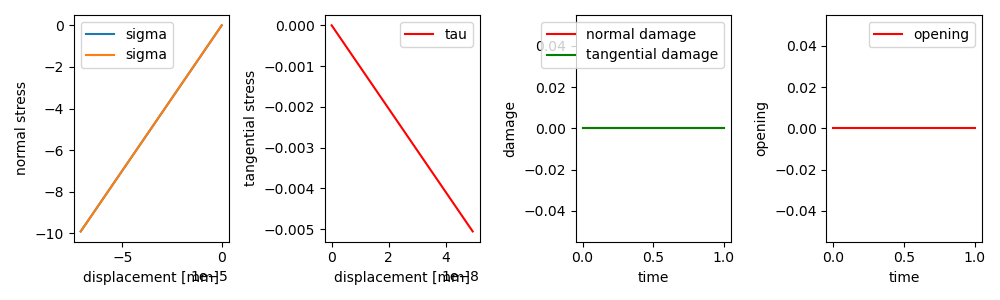

In [38]:
time = m.hist.t
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10, 3))

ax1.plot(U_compression, sig_pi_N[:,0,0].flatten(), label='sigma')
ax1.plot(U_compression, sig_pi_N[:,0,1].flatten(), label='sigma')
ax1.set_xlabel('displacement [mm]')
ax1.set_ylabel('normal stress')
ax1.legend()

ax2.plot(U_slide, sig_pi_Tx[:,0,0].flatten(), color='red', label='tau')
ax2.set_xlabel('displacement [mm]')
ax2.set_ylabel('tangential stress')
ax2.legend()

ax3.plot(time, omega_Nx[:,0,0].flatten(), color='red', label='normal damage')
ax3.plot(time, omega_Tx[:,0,0].flatten(), color='green', label='tangential damage')

ax3.set_xlabel('time')
ax3.set_ylabel('damage')
ax3.legend()

ax4.plot(time, u_pi_N[:,0,0].flatten(), color='red', label='opening')
ax4.set_xlabel('time')
ax4.set_ylabel('opening')
ax4.legend()
plt.tight_layout()


In [551]:
# if True:
#     mlab.options.backend = 'envisage'
#     mlab.options.offscreen = False # 'envisage'
#     f_strain = mlab.figure()
#     scene = mlab.get_engine().scenes[-1]
#     scene.name = 'stress'
#     strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
#     strain_viz.setup()
#     strain_viz.warp_vector.filter.scale_factor = 0.1
#     strain_viz.plot(s.tstep.t_n)
#     mlab.show()

## Sliding dc

In [26]:
material_params =  dict(
     E_T=1e7, gamma_T=1e5, K_T=0, S_T=0.5, c_T=6, bartau=3, 
     E_N=1e7, S_N=0.5, c_N = 3, m = 0.05, f_t=2, f_c=60, f_c0 = 40, eta=0.)
bond_m = Slide34(**material_params)

In [27]:
lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

lower_slide = BCSlice(slice=xd_lower.mesh[-1, :, -1, :], var='u', dims=[0], value=0.001)
lower_slide_dofs = lower_slide_dummy.dofs

upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
         var='u', dims=[1], value=0.01)

compression_dofs = upper_compression_slice.dofs

bc1 =   [lower_fixed_0, upper_fixed_1, lower_slide]

In [28]:
m = TStepBC(
    domains=[(xd_lower, m1),
             (xd_upper, m2),
             (xd12, bond_m),
             ]
)

In [29]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 100
s.tline.step = 0.01
s.tstep.fe_domain.serialized_subdomains

In [30]:
xd12.hidden = True
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(1), 
	 0.02(1), 
	 0.03(1), 
	 0.04(1), 
	 0.05(1), 
	 0.06(1), 
	 0.07(1), 
	 0.08(1), 
	 0.09(1), 
	 0.10(1), 
	 0.11(1), 
	 0.12(1), 
	 0.13(1), 
	 0.14(1), 
	 0.15(1), 
	 0.16(1), 
	 0.17(1), 
	 0.18


StopIteration: Warning: convergence not reached in 100 iterations

In [31]:
F_to = m.hist.F_t
U_to = m.hist.U_t
U_compression = np.average(U_to[:, compression_dofs], axis=-1)
U_slide = np.average(U_to[:, lower_slide_dofs], axis=-1)

states_t = [states_t[2] for states_t in m.hist.state_vars]
var_names = states_t[0].keys()
EpsSig_t = {
    var_name: np.array([ state_dict[var_name] for state_dict in states_t ]) 
    for var_name in var_names 
}
u_pi_N = EpsSig_t['w_pi']
u_pi_Tx = EpsSig_t['s_pi_x']
sig_pi_N = EpsSig_t['sig_pi']
sig_pi_Tx = EpsSig_t['tau_pi_x']
sig_pi_Ty = EpsSig_t['tau_pi_y']
omega_Nx = EpsSig_t['omega_N']
omega_Tx = EpsSig_t['omega_T']
x_m = xd12.x_Eia[:,:,0].flatten()

In [32]:
time = m.hist.t
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10, 3))

ax1.plot(U_compression, sig_pi_N[:,0,0].flatten(), label='sigma')
ax1.plot(U_compression, sig_pi_N[:,0,1].flatten(), label='sigma')
ax1.set_xlabel('displacement [mm]')
ax1.set_ylabel('normal stress')
ax1.legend()

ax2.plot(U_slide, sig_pi_Tx[:,0,0].flatten(), color='red', label='tau')
ax2.set_xlabel('displacement [mm]')
ax2.set_ylabel('tangential stress')
ax2.legend()

ax3.plot(time, omega_Nx[:,0,0].flatten(), color='red', label='normal damage')
ax3.plot(time, omega_Tx[:,0,0].flatten(), color='green', label='tangential damage')

ax3.set_xlabel('time')
ax3.set_ylabel('damage')
ax3.legend()

ax4.plot(time, u_pi_N[:,0,0].flatten(), color='red', label='opening')
ax4.set_xlabel('time')
ax4.set_ylabel('opening')
ax4.legend()
plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [33]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Sliding fc

In [34]:
lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
upper_fixed_1 = BCSlice(slice=xd_upper.mesh[-1, :, 0-1, :], var='u', dims=[0], value=0)

lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=0)
Force = 4 / len(lower_slide.dofs)
lower_slide_force = [BCDof(var='f', dof=dof, value = Force) 
            for dof in lower_slide.dofs]

bc1 =   [lower_fixed_0, upper_fixed_1] + lower_slide_force

In [35]:
m = TStepBC(
    domains=[(xd_lower, m1),
             (xd_upper, m2),
             (xd12, bond_m),
             ]
)

In [36]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 100
s.tline.step = 0.01
s.tstep.fe_domain.serialized_subdomains

In [37]:
xd12.hidden = True
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(1), 
	 0.02(1), 
	 0.03(1), 
	 0.04(1), 
	 0.05(1), 
	 0.06(1), 
	 0.07(1), 
	 0.08(1), 
	 0.09(1), 
	 0.10(1), 
	 0.11(1), 
	 0.12(1), 
	 0.13(1), 
	 0.14(1), 
	 0.15(1), 
	 0.16(1), 
	 0.17(1), 
	 0.18(1), 
	 0.19(1), 
	 0.20(1), 
	 0.21(1), 
	 0.22(1), 
	 0.23(1), 
	 0.24(1), 
	 0.25(1), 
	 0.26(1), 
	 0.27(1), 
	 0.28(1), 
	 0.29(1), 
	 0.30(1), 
	 0.31(1), 
	 0.32(1), 
	 0.33(1), 
	 0.34(1), 
	 0.35(1), 
	 0.36(1), 
	 0.37(1), 
	 0.38(1), 
	 0.39(1), 
	 0.40(1), 
	 0.41(1), 
	 0.42(1), 
	 0.43(1), 
	 0.44(1), 
	 0.45(1), 
	 0.46(1), 
	 0.47(1), 
	 0.48(1), 
	 0.49(1), 
	 0.50(1), 
	 0.51(1), 
	 0.52(1), 
	 0.53


StopIteration: Warning: convergence not reached in 100 iterations

In [38]:
states_t = [states_t[2] for states_t in m.hist.state_vars]
var_names = states_t[0].keys()
EpsSig_t = {
    var_name: np.array([ state_dict[var_name] for state_dict in states_t ]) 
    for var_name in var_names 
}
u_pi_N = EpsSig_t['w_pi']
u_pi_Tx = EpsSig_t['s_pi_x']
sig_pi_N = EpsSig_t['sig_pi']
sig_pi_Tx = EpsSig_t['tau_pi_x']
sig_pi_Ty = EpsSig_t['tau_pi_y']
omega_Nx = EpsSig_t['omega_N']
omega_Tx = EpsSig_t['omega_T']
x_m = xd12.x_Eia[:,:,0].flatten()

In [39]:
time = m.hist.t
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.plot(time, sig_pi_N[:,0,0].flatten(), label='sigma')
ax1.plot(time, sig_pi_N[:,0,1].flatten(), label='sigma')
ax1.set_xlabel('time')
ax1.set_ylabel('normal stress')
ax1.legend()

ax2.plot(time, sig_pi_Tx[:,0,0].flatten(), color='red', label='tau')
ax2.set_xlabel('time')
ax2.set_ylabel('tangential stress')
ax2.legend()

ax3.plot(time, omega_Nx[:,0,0].flatten(), color='red', label='normal damage')
ax3.plot(time, omega_Tx[:,0,0].flatten(), color='green', label='tangential damage')

ax3.set_xlabel('time')
ax3.set_ylabel('damage')
ax3.legend()

ax4.plot(time, u_pi_N[:,0,0].flatten(), color='red', label='opening')
ax4.set_xlabel('time')
ax4.set_ylabel('opening')
ax4.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [78]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()